# Using topic modeling to extract topics from documents

Sometimes you have a nice big set of documents, and all you wish for is to know what's hiding inside. But without reading them, of course! Two approaches to try to lazily get some information from your texts are **topic modeling** and **clustering**.

<p class="reading-options">
  <a class="btn" href="/text-analysis/introduction-to-topic-modeling">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/Introduction to topic modeling.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/Introduction to topic modeling.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

--2022-05-13 02:40:14--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  27.4MB/s    in 0.2s    

2022-05-13 02:40:15 (27.4 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2022-05-13 02:40:15--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

## How computers read

I'm going to tell you a big secret: **computers are really really really bad at reading documents and figuring out what they're about.** Text is for _people_ to read, people with a collective knowledge of The World At Large and a history of reading things and all kinds of other tricky secret little things we don't think about that help us understand what a piece of text means.

When dealing with understanding content, computers are good for _very specific situations_ to do _very specific things_. Or alternatively, to do a not-that-great job when you aren't going to be terribly picky about the results.

Do I sound a little biased? Oh, but aren't we all. It isn't going to stop us from talking about it, though!

Before we start, **let's make some assumptions:**

* When you're dealing with documents, each document is (typically) about something.
* You know each document is about by looking at the words in the document.
* Documents with similar words are probably about similar things. 

We have two major options available to us: **topic modeling** and **clustering**. There's a lot of NLP nuance going on between the two, but we're going to keep it simple:

**Topic modeling** is if each document can be about **multiple topics**. There might be 100 different topics, and a document might be 30% about one topic, 20% about another, and then 50% spread out between the others.

**Clustering** is if each document should only fit into **one topic**. It's an all-or-nothing approach.

The most important part of _all of this_ is the fact that **the computer figures out these topics by itself**. You don't tell it what to do! If you're teaching the algorithm what different specific topics look like, that's **classification.** In this case we're just saying "hey computer, please figure this out!"

Let's get started.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# These styles look nicer than default pandas
plt.style.use('ggplot')

# We'll be able to see more text at once
pd.set_option("display.max_colwidth", 100)

In [1]:
from google.colab import drive

In [2]:
drive.mount("/gdrive")

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/"Spring 2022"/"IPHS 300.00"/"Final Project"

/gdrive/MyDrive/Spring 2022/IPHS 300.00/Final Project


## Attempt one: Recipes

### Our dataset

We're going to start with analyzing **about 36,000 recipes**. Food is interesting because you can split it so many ways: by courses, or by baked goods vs meat vs vegetables vs others, by national cuisine...

In [6]:
recipes = pd.read_csv("data.csv")
recipes.head()

,Id,Channel,Subscribers,Title,CC,URL,Released,Views,Category,Transcript,Length
0,FozCkl1xj-w,JRE Clips,6.28M subscribers,Former CIA Agent Breaks Down Jeffrey Epstein Case,0,https://www.youtube.com/watch?v=FozCkl1xj-w,2 years ago,7.9M views,Blog,the Joe Rogan experience well how about the other so you gotta go to okay how about the other pr...,13:32
1,RN8yoi-e2yc,Mythical Kitchen,1.9M subscribers,$420 Pizza Hut Stuffed Crust Pizza | Fancy Fast Food | Mythical Kitchen,1,https://www.youtube.com/watch?v=RN8yoi-e2yc,NaN,2.7M views,Food,"- Oh, that's dirty.\r\n- Wow! - Whoa.\r\n- You're a dirty girl. (upbeat music) - Hey man. - What...",24:26
2,IugcIAAZJ2M,Munchies,4.59M subscribers,The Iconic $1 Pizza Slice of NYC | Street Food Icons,0,https://www.youtube.com/watch?v=IugcIAAZJ2M,2 years ago,11M views,Food,if you want good pizza come to st marks it's the best pizza i'll be in any borough i always come...,7:51
3,JiEO6F8i0eU,Parks and Recreation,282K subscribers,Ron Swanson: The Papa of Pawnee | Parks and Recreation,0,https://www.youtube.com/watch?v=JiEO6F8i0eU,3 years ago,2.3M views,"Entertainment,Comedy",April where have you been over two phone calls came in uninvited we're raising money for my coll...,10:06
4,1T4XMNN4bNM,Vsauce,17.4M subscribers,What's The Most Dangerous Place on Earth?,1,https://www.youtube.com/watch?v=1T4XMNN4bNM,9 years ago,21M views,Science,"Hey, Vsauce. Michael here. 93% of all the\r\nhumans who have ever lived are dead. For every pers...",9:29


In order to analyze the text, we'll need to count the words in each recipe. To do that we're going to use a **stemmed TF-IDF vectorizer** from scikit-learn.

* **Stemming** will allow us to combine words like `tomato` and `tomatoes`
* Using **TF-IDF** will allow us to devalue common ingredients like salt and water

I'm using the code from [the reference section](https://investigate.ai/reference/vectorizing/#stem-and-vectorize), just adjusted from a `CountVectorizer` to a `TfidfVectorizer`, and set it so ingredients have to appear in at least **fifty recipes**.

In [7]:
!pip install pystemmer

     |████████████████████████████████| 559 kB 14.1 MB/s 
  Created wheel for pystemmer: filename=PyStemmer-2.0.1-cp37-cp37m-linux_x86_64.whl size=425657 sha256=878259aa5932d75e8d5583073e1beb325b1c504721c095d1a4665cffa3863209
  Stored in directory: /root/.cache/pip/wheels/30/6d/40/0d17a498c5009922dbb3ddaca3d3652387ba94cc96142001f0
Successfully built pystemmer


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

In [9]:
vectorizer = StemmedTfidfVectorizer(min_df=50)
matrix = vectorizer.fit_transform(recipes.Transcript)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,10,100,1000,11,12,120,13,14,...,you,young,younger,your,yourself,youtub,yup,zero,zone,zoom
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.377923,0.00997,0.0,0.015037,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.006169,0.000000,0.008713,0.003618,0.0,0.000000,0.008368,0.0,0.0,0.0,...,0.283297,0.00000,0.0,0.044852,0.003433,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.011031,0.018653,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.119702,0.00000,0.0,0.016003,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.018380,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.477132,0.00000,0.0,0.033751,0.017437,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.015435,0.013049,0.016258,0.0,0.021013,0.000000,0.0,0.0,0.0,...,0.107192,0.00000,0.0,0.059712,0.000000,0.017496,0.0,0.0,0.075351,0.0


Looks like we have 752 ingredients! Yes, there are some numbers in there and probably other things we aren't interested in, but let's stick with it for now.

## Topic modeling

There are multiple techniques for topic modeling, but in the end they do the same thing: **you get a list of topics, and a list of words associated with each topic.**

Let's tell it to break them down into **five topics.**

In [12]:
from sklearn.decomposition import NMF

model = NMF(n_components=10)
model.fit(matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


NMF(n_components=10)

Why five topics? **Because we have to tell it _something_.** Our job is to decide the number of topics, and it's the computer's job to find the topics. We'll talk about how to pick the "right" number later, but for now: it's magic.

Fitting the model allowed it to "learn" what the ingredients are and how they're organized, we just need to find out what's inside. Let's ask for the **top ten terms in each group.**

In [13]:
n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_features = [feature_names[i] for i in topic.argsort()][::-1][:n_words]
    top_n = ' '.join(top_features)
    topic_list.append(f"topic_{'_'.join(top_features[:3])}") 

    print(f"Topic {topic_idx}: {top_n}")

Topic 0: the and to of it is in this game for
Topic 1: you to your me re that and do have what
Topic 2: the he and to was of in his they him
Topic 3: it like that and this of so is was but
Topic 4: the car it and drive is wheel race in you
Topic 5: the of that in univers star is to and galaxi
Topic 6: we to and so this that our go re here
Topic 7: the it and of to in cook gonna is flavor
Topic 8: oh you the it this okay yeah that is my
Topic 9: __ chef yeah that you he it the oh like


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
print(topic_list)

['topic_the_and_to', 'topic_you_to_your', 'topic_the_he_and', 'topic_it_like_that', 'topic_the_car_it', 'topic_the_of_that', 'topic_we_to_and', 'topic_the_it_and', 'topic_oh_you_the', 'topic____chef_yeah']


Those actually seem like _pretty good topics_. Italian-ish, then baking, then Chinese, maybe Latin American or Indian food, and then dairy. What if we did it with **fifteen topics** instead?

In [15]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0: the it is this of so you in on and
Topic 1: you your to me re do the what know no
Topic 2: the of and to in they was for that were
Topic 3: oh okay my it this that god no yeah gonna
Topic 4: car the it and drive wheel race in to that
Topic 5: the of univers star galaxi to in that and hole
Topic 6: we to and so this go re our here gonna
Topic 7: the it and of cook to in flavor chees gonna
Topic 8: to and that of for your in is be use
Topic 9: __ chef you yeah the that it like on yes
Topic 10: and it was to my like just had so that
Topic 11: that like it you is yeah so of know they
Topic 12: music applaus foreign my excit intens girl laughter kid speak
Topic 13: he his him that to the was in is trump
Topic 14: game the you of play and fuck player is this


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This is where we start to see **the big difference between categories and topics**. The grouping with five groups seemed very much like cuisines - Italian, Chinese, etc. But now that we're breaking it down further, the groups have changed a bit.

They're now **more like classes of ingredients.** Baking gets a category - `chicken breast boneless skinless` and so do generic Mediterranean ingredients - `oliv extra virgin oil clove garlic fresh salt`. The algorithm got a little confused about black pepper vs. hot pepper flakes vs green/yellow bell peppers when it created `pepper bell red green onion celeri flake black`, but we understand what it's going for.

Remember, the important thing about topic modeling is that every row in our dataset is a **combinations of topics**. It might be a little bit about one thing, a little bit less about another, etc etc. Let's take a look at how that works.

In [16]:
# If we don't want 'real' names for the topics, we can run this line
# topic_list = [f"topic_{i}" for i in range(model.n_components_)]

# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(2)

,topic_the_it_is,topic_you_your_to,topic_the_of_and,topic_oh_okay_my,topic_car_the_it,topic_the_of_univers,topic_we_to_and,topic_the_it_and,topic_to_and_that,topic____chef_you,topic_and_it_was,topic_that_like_it,topic_music_applaus_foreign,topic_he_his_him,topic_game_the_you
0,0.428911,7.637573,7.747889,0.541394,0.201457,0.0,0.668425,0.000000,0.0,5.398475,4.191945,10.363386,0.000000,5.865095,0.0
1,1.424302,4.866694,0.489358,3.091461,0.960073,0.0,8.278658,15.109108,0.0,0.000000,0.000000,6.598518,0.264213,0.065817,0.0


Our first recipe is primary `topic_3` with a rating of 2.44, but it's also a bit topic 0 and topic 8 with scores of 1.5 and 1.36.

Our second recipe is a bit bolder - it scores a whopping 5.7 in `topic_7`, with 0, 8 and 14 coming up in the 2.5-3 range.

Let's combine this topics dataframe with our **original dataframe** so we can see it all in one place.

In [ ]:
merged = recipes.merge(topics, right_index=True, left_index=True)
merged.head(2)

,cuisine,id,ingredient_list,topic_pepper_bell_red,topic_flour_purpos_all,topic_sauc_soy_sesam,topic_tortilla_cream_shred,topic_chees_parmesan_grate,topic_lime_cilantro_fresh,topic_chicken_breast_boneless,topic_ground_black_pepper,topic_chili_seed_powder,topic_sugar_egg_vanilla,topic_oliv_extra_virgin,topic_white_wine_vinegar,topic_dri_oregano_tomato,topic_lemon_juic_fresh,topic_water_yeast_warm
0,greek,10259,"romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo...",1.437035,0.000000,0.00000,2.667979,1.616348,0.225044,0.0,0.506896,0.000000,0.00000,2.543676,0.0,0.475955,0.0,0.000000
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, ye...",2.444909,3.031973,0.17651,1.409350,0.000000,0.000000,0.0,5.706696,0.495151,1.58009,0.544958,0.0,1.603470,0.0,0.245135


Now we can do things like...

* Uncover possible topics discussed in the dataset
* See how many documents cover each topic
* Find the top documents in each topic

And **graph it!** Let's see what our distribution of topics looks like.

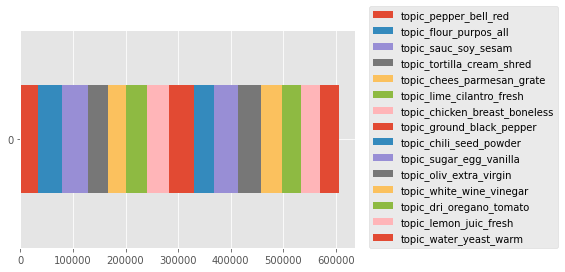

In [ ]:
ax = merged[topic_list].sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Suspiciously even, but that's an investigation for another day. Let's try a different dataset that splits a little differently.

## Attempt two: State of the Union addresses

One of the fun things to do with topic modeling is see how **things change over time.** For this example, we're going to reproduce an assignment from [Jonathan Stray's Computational Journalism course](http://www.compjournalism.com/?p=208).

At the beginning of each year, the President of the United States traditionally addresses Congress in a speech called the State of the Union. It's a good way to judge what's important in the country at the time, because the speech is sure to be used as a platform to address the legislative agenda for the year. Let's see if topic modeling can help illustrate how it's **changed over time.**

### Our data

We have a simple CSV of State of the Union addresses, nothing too crazy.

In [ ]:
speeches = pd.read_csv("data/state-of-the-union.csv")
speeches.sample(5)

,year,content
195,1983,"\nState of the Union Address\nRonald Reagan\nJanuary 25, 1983\n\nMr. Speaker, Mr. President, dis..."
59,1848,"\nState of the Union Address\nJames Polk\nDecember 5, 1848\n\nFellow-Citizens of the Senate and ..."
177,1965,"\nState of the Union Address\nLyndon B. Johnson\nJanuary 4, 1965\n\nOn this Hill which was my ho..."
127,1916,"\nState of the Union Address\nWoodrow Wilson\nDecember 5, 1916\n\nGENTLEMEN OF THE CONGRESS:\n\n..."
80,1869,"\nState of the Union Address\nUlysses S. Grant\nDecember 6, 1869\n\nTo the Senate and House of R..."


It's not too many, only a little over 226. Because it's a smaller dataset, we're able to do more computationally intensive forms of topic modeling (LDA, for example) without sitting around getting bored.

In [ ]:
speeches.shape

(226, 2)

To help the analysis out a bit, we're going to clean the text. Only a little bit, though - we'll just remove anything that isn't a word.

In [ ]:
# Remove non-word characters, so numbers and ___ etc
speeches.content = speeches.content.str.replace("[^A-Za-z ]", " ")
speeches.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,year,content
0,1790,George Washington January Fellow Citizens of the Senate and House of Representatives ...
1,1790,State of the Union Address George Washington December Fellow Citizens of the Senate an...
2,1791,State of the Union Address George Washington October Fellow Citizens of the Senate an...
3,1792,State of the Union Address George Washington November Fellow Citizens of the Senate an...
4,1793,State of the Union Address George Washington December Fellow Citizens of the Senate an...


### Vectorize

We're going to use the same TF-IDF vectorizer we used up above, which stems in addition to just vectorizing. We'll reproduce the code down here for completeness's sake (and easy cut-and-paste).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# English stemmer from pyStemmer
stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

With our first pass we'll **vectorize everything**, no limits!

In [ ]:
vectorizer = StemmedTfidfVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,aana,aaron,abandon,abat,abba,abbrevi,abdic,abduct,aberdeen,...,zigzag,zimbabw,zimbabwean,zinc,zion,zollverein,zone,zoolog,zoom,zuloaga
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.050896,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Running NME/NMF topic modeling

Now we'll leap into topic modeling. We'll look at fifteen topics, since we're covering a long span of time where lots of different things may have happened.

In [ ]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0: state govern constitut unit mexico congress territori power countri shall
Topic 1: program year feder nation govern econom billion new increas develop
Topic 2: ve job american america year tonight work peopl help let
Topic 3: shall million countri vessel nation peac public necessari citizen time
Topic 4: govern nation law great peopl men need interst work countri
Topic 5: govern agricultur nation feder industri public countri year bank congress
Topic 6: year state increas report law unit cent offic congress secretari
Topic 7: terrorist iraq america iraqi terror al tonight american help afghanistan
Topic 8: govern bank public state duti countri subject treasuri peopl general
Topic 9: state gentlemen unit nation public law measur indian provis object
Topic 10: govern state unit treati american countri relat congress convent intern
Topic 11: war enemi victori fight japanes american forc british command nation
Topic 12: world nation soviet free peac peopl freedom defens econom war

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Let's be honest with ourselves: **we expected something a bit better.** So many of these words are so _common_ that it doesn't do much to convince me these are meaningful concepts.

### Adjusting our min and max document frequency

One way to cut those overly broad topics from our topic model is to **remove them from the vectorizer.** Instead of accepting _all_ words, we can set minimum or maximum limits.

Let's only accept words used **in at least 5 speeches**, but also **don't appear in more than half of the speeches**.

In [ ]:
vectorizer = StemmedTfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
matrix = vectorizer.fit_transform(speeches.content)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abat,abdic,abey,abhorr,abid,ablest,abli,abnorm,aboard,...,young,younger,youngest,youth,yukon,zeal,zealand,zealous,zero,zone
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062207,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.061534,0.0,0.0
3,0.0,0.076291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.047783,0.0,0.065893,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


And now we'll **check the topic model.**

In [ ]:
model = NMF(n_components=15)
model.fit(matrix)

n_words = 10
feature_names = vectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0: island commission cuba consular diplomat arbitr award pension spain exhibit
Topic 1: school tonight challeng budget parent child job drug medicar colleg
Topic 2: spain coloni articl intercours tribe port likewis augment commenc florida
Topic 3: program billion today budget goal area level farm inflat percent
Topic 4: corpor interst forest island philippin railroad supervis canal panama standpoint
Topic 5: terrorist iraq iraqi terror al tonight afghanistan regim qaeda fight
Topic 6: mexico texa mexican oregon annex california articl steamer postag levi
Topic 7: silver gold circul currenc note coin coinag cent speci bond
Topic 8: method cent veteran tariff board farmer consolid depress farm railway
Topic 9: gentlemen militia tribe legislatur disposit ensu port frontier expedi requisit
Topic 10: fight enemi japanes democraci victori today tank task nazi plane
Topic 11: ve job tonight ll spend deficit cut budget don inflat
Topic 12: soviet communist atom aggress korea weapon threa

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


That's looking a little more interesting! Lots of references to wars and political conflict, along with slavery and monetary policy.

## Visualizing the outcome

We can get a better handle on what our data looks like through a little visualization. We'll start by loading up the **topic popularity dataframe**. Remember that each row is one of our speeches.

In [ ]:
# Convert our counts into numbers
amounts = model.transform(matrix) * 100

# Set it up as a dataframe
topics = pd.DataFrame(amounts, columns=topic_list)
topics.head(2)

,topic_island_commission_cuba,topic_school_tonight_challeng,topic_spain_coloni_articl,topic_program_billion_today,topic_corpor_interst_forest,topic_terrorist_iraq_iraqi,topic_mexico_texa_mexican,topic_silver_gold_circul,topic_method_cent_veteran,topic_gentlemen_militia_tribe,topic_fight_enemi_japanes,topic_ve_job_tonight,topic_soviet_communist_atom,topic_kansa_slave_slaveri,topic_vietnam_tonight_billion
0,0.0,0.422030,0.0,0.0,0.0,0.0,0.0,2.830847,0.0,28.777082,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.434299,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,34.450043,0.0,0.0,0.0,0.0,0.666371


The first row is our first speech, the second row is our second speech, and so on.

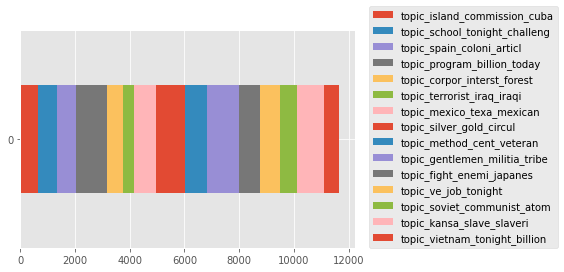

In [ ]:
ax = topics.sum().to_frame().T.plot(kind='barh', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Again, pretty even! A few are larger or smaller, but overall the topics seem pretty evenly distributed.

Looking at things over all time doesn't mean much, though, we're interseted in **change over time**.

The hip way to do this is with a **streamgraph**, which is a stacked area graph that centers on the vertical axis. Usually you'd have to merge the two dataframes in order to graph, but we can sneakily get around it since we aren't plotting with pandas (plotting streamgraphs requires directly talking to matplotlib).

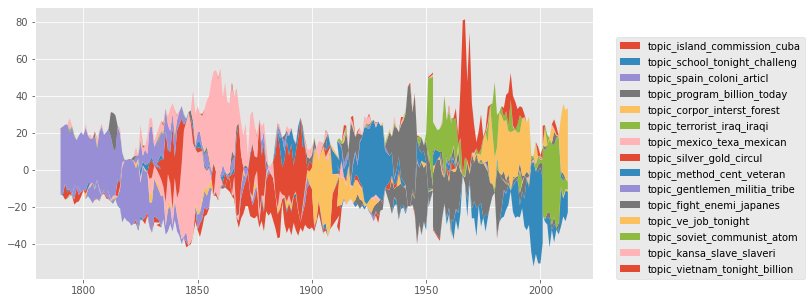

In [ ]:
x_axis = speeches.year
y_axis = topics

fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(x_axis, y_axis.T, baseline='wiggle', labels=y_axis.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

I know that "Presidents talk about current news topics" is probably not the most exciting things you've ever seen, but you can watch things rise and fall easily enough.

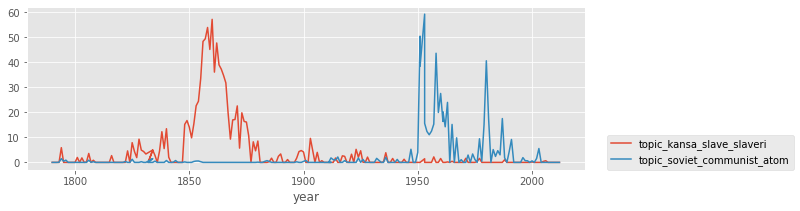

In [ ]:
merged = topics.join(speeches)

ax = merged.plot(x='year', y=['topic_kansa_slave_slaveri', 'topic_soviet_communist_atom'], figsize=(10,3))
ax.legend(loc=(1.04,0))

## So what do you do with this?

Good question. TODO.

## Review

In this section we looked at **topic modeling**, a technique of extracting topics out of text datasets. Unlike clustering, where each document is assigned one category, in topic modeling **each document is considered blend of different topics.**

You don't need to "teach" a topic model anything about your dataset, you just let it loose and it comes back with what terms represent each topic. The only thing you need to give it is the **number of topics to find**.

The way you preprocess the text is very important to a topic model. We found that common words ended up appearing in many topics unless we used `max_df=` in our vectorizer to filter out high-frequency words.

There are many different algorithms to use for topic modeling, but we're saving that for a later section.

## Discussion topics

TODO